In [17]:
import json
import gzip
import pandas as pd
import numpy as np 
import tensorflow as tf 
from sklearn.utils import shuffle
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.losses import sparse_categorical_crossentropy
import matplotlib.pyplot as plt



In [18]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(r"C:\Users\rishi\ml_projects\reviews\Video_Games.json.gz")
df=df.drop(["reviewTime","reviewerID","vote","style","image","unixReviewTime","reviewerName","asin"],axis=1)
df=shuffle(df)
df=df.reset_index(drop=True)
df=df[:500000]
df['overall']=df['overall'].apply(lambda x: float(x))
df['reviewText']=df['reviewText'].apply(lambda x: str(x))
df['summary']=df['summary'].apply(lambda x: str(x))
train,valid,test=df[:400000], df[460000:480000], df[480000:500000]


In [19]:
train.head(10)

,overall,verified,reviewText,summary
0,5.0,True,"I admit, I was a bit leery of the low price on...",these things actually work!
1,4.0,True,My son loved it,Great gift
2,1.0,True,Very bad. It will break really fast. I can't h...,Waste Of Money!
3,1.0,True,The game sucks....,One Star
4,5.0,False,"Don't get me wrong, farcry 3 was an o.k. game,...",Re:Better than Farcry 3
5,5.0,True,it beeter then the acckilam wi.e rless one th...,it better
6,5.0,True,Ball is life,Five Stars
7,4.0,True,It's ok,Four Stars
8,1.0,True,Im just getting around to writing this review ...,Didn't work
9,5.0,True,Love this game,Five Stars


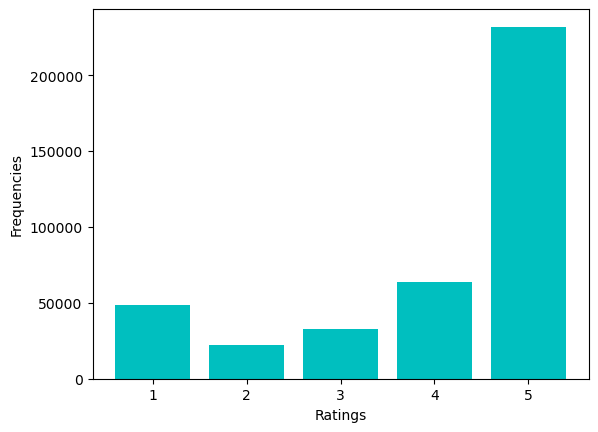

In [50]:
stars=[]
counts=train['overall'].value_counts()
for i in range(1,6):
    stars.append(counts.get(i,0))
plt.bar(range(1,6),stars,color='c')
plt.xlabel('Ratings')
plt.ylabel('Frequencies')
plt.show()

In [20]:
trainset=tf.data.Dataset.from_tensor_slices((train['reviewText'],train['overall']))
validset=tf.data.Dataset.from_tensor_slices((valid['reviewText'],valid['overall']))
testset=tf.data.Dataset.from_tensor_slices((test['reviewText'],test['overall']))
textvec=TextVectorization(output_mode='multi_hot',max_tokens=20000,ngrams=3)
text_train=trainset.map(lambda x, y: x)
textvec.adapt(text_train)


In [21]:
batchsize = 32
train_ngram_ds = trainset.map(
 lambda x, y: (textvec(x), int(y)-1),
 num_parallel_calls=8)
valid_ngram_ds = validset.map(
 lambda x, y: (textvec(x), int(y)-1),
 num_parallel_calls=8)
test_ngram_ds = testset.map(
 lambda x, y: (textvec(x), int(y)-1),
 num_parallel_calls=8)
train_ngram_ds=train_ngram_ds.batch(batchsize)
test_ngram_ds=test_ngram_ds.batch(batchsize)
valid_ngram_ds=valid_ngram_ds.batch(batchsize)


In [22]:
for ele,label in train_ngram_ds:
    print(ele.ndim)
    print(ele.shape)
    print(label.shape)
    print(ele[0])
    print(label[0])
    break

2
(32, 20000)
(32,)
tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
tf.Tensor(4, shape=(), dtype=int32)


In [23]:
inputs=keras.Input(shape=(20000,))
features=layers.Dense(16,activation='relu')(inputs)
features=layers.Dropout(0.5)(features)
outputs=layers.Dense(5,activation='softmax')(features)
model=keras.Model(inputs,outputs)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 320,101
Trainable params: 320,101
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
watch=model.fit(train_ngram_ds,epochs=4,validation_data=valid_ngram_ds)

Epoch 1/4
12500/12500 [==============================] - 80s 6ms/step - loss: 0.7602 - accuracy: 0.7055 - val_loss: 0.7713 - val_accuracy: 0.7096
Epoch 2/4
12500/12500 [==============================] - 79s 6ms/step - loss: 0.7555 - accuracy: 0.7085 - val_loss: 0.7750 - val_accuracy: 0.7086
Epoch 3/4
12500/12500 [==============================] - 77s 6ms/step - loss: 0.7494 - accuracy: 0.7093 - val_loss: 0.7824 - val_accuracy: 0.7103
Epoch 4/4
12500/12500 [==============================] - 80s 6ms/step - loss: 0.7453 - accuracy: 0.7113 - val_loss: 0.7858 - val_accuracy: 0.7086


In [30]:
y_predictions=model.predict(test_ngram_ds)
finalpred=[]
for row in y_predictions:
    finalpred.append(np.argmax(row)+1)
finalpred=np.array(finalpred)
actual=test['overall'].apply(lambda x: int(x))
actual=np.array(actual)

625/625 [==============================] - 4s 6ms/step


In [31]:
def precision_recall(class_num,predictions,actual):
    tp=0
    fp=0
    fn=0
    tn=0
    for i in range(0,len(predictions)):
        if(predictions[i]==class_num and actual[i]!=class_num):
            fp=fp+1
        elif(predictions[i]==class_num and actual[i]==class_num):
            tp=tp+1
        elif(predictions[i]!=class_num and actual[i]==class_num):
            fn=fn+1
        elif(predictions[i]!=class_num and actual[i]!=class_num):
            tn=tn+1
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    return(precision,recall)
def multi_class_precision_recall(predictions,actual):
    precision_avg=0
    recall_avg=0
    for i in range(1,6):
        prec,rec=precision_recall(i,predictions,actual)
        precision_avg+=prec
        recall_avg+=rec
    precision_avg=precision_avg/5
    recall_avg=recall_avg/5
    return (precision_avg,recall_avg)
def calc_accuracy(predictions,actual):
    correct=0
    for i in range(0, len(predictions)):
        if(predictions[i]==actual[i]):
            correct+=1
    return correct/len(predictions)
precision,recall=multi_class_precision_recall(finalpred,actual)
accuracy=calc_accuracy(finalpred,actual)
print(f"precision:{precision}  , recall:{recall}, accuracy:{accuracy}")

precision:0.5569650929361625  , recall:0.4674612106236042, accuracy:0.70915
